In [1]:
from glob import glob
import torch
from os import listdir
from os.path import splitext
import logging, librosa
from torch.utils.data import Dataset
import numpy as np
import torch
from spectrogram import Spectrogram
from matplotlib import cm
from librosa import display
import matplotlib.pyplot as plt
import torchaudio
from PIL import Image
import IPython
import scipy.signal as signal
from sklearn import preprocessing
from torch.utils.data import DataLoader, random_split
import torchvision.utils as vutils
import torchvision.transforms as transforms
import os
from itertools import islice
%matplotlib inline

In [2]:
path="/Users/zombie/Downloads/datadrive/ljspeech/wavs/"
revPath="/Users/zombie/Downloads/datadrive/ljspeech/revWavs/"
checkpoint="/Users/zombie/2kBCE.pt"

In [3]:
from glob import glob
from os import listdir
import numpy as np
from itertools import chain, cycle
from torch.utils.data import IterableDataset
import torchvision.transforms as transforms
import librosa, torch, random
from utils import polarToComplex, complexToPolar

In [4]:
class TestDataset(IterableDataset):
    def __init__(self, wavPath, samplingRate, nfft, winLength, hopLength, shuffle=True):
        self.sr = samplingRate
        self.nfft = nfft
        self.window = torch.hamming_window(32)
        self.winLength = winLength
        self.wavPath = wavPath
        self.hopLength=hopLength
        self.ids = [i for i in listdir(wavPath) if not i.startswith('.')]

        if shuffle:
            random.shuffle(self.ids)

    def __len__(self):
        return len(self.ids)

    def transform(self, X):
        return (X - X.min()) / (X.max() - X.min())

    def squaredChunks(self, spec):
        n = self.nfft // 2
        l = spec.shape[1]
        for i in range(0, l - l % n, n):
            yield spec[:, i:i + n].unsqueeze(0).numpy()
            

    def polarToAudio(self, magBatch, phaseBatch):
        mag=[]
        phase=[]
        for idx, subMag in enumerate(magBatch):
            mag.append(subMag)
            phase.append(phaseBatch[idx])
        mag=torch.cat(mag, dim=2).squeeze(0)
        phase=torch.cat(phase, dim=2).squeeze(0)
        stft=Spectrogram.polarToComplex(mag, phase)
        audio=torch.istft(stft, n_fft=self.nfft, window=self.window, win_length=self.winLength, hop_length=self.hopLength)
        return audio
        

    def getAudio(self, idx):
        org = glob(self.wavPath + idx)[0]
        org, _ = torchaudio.load(org)
#         resamp=torchaudio.transforms.Resample(new_freq=self.sr)
#         org=resamp(org)
        org = torch.stft(org, n_fft=self.nfft, window=self.window, win_length=self.winLength, hop_length=self.hopLength, return_complex=True)
        mag, phase=Spectrogram.complexToPolar(org, deg=True)
        mag = torch.FloatTensor(list(self.squaredChunks(mag[0])))
        phase=torch.FloatTensor(list(self.squaredChunks(phase[0])))
        for i, v in enumerate(mag):
            yield (v**2, phase[i])

    def getStream(self, ids):
        yield from chain.from_iterable(map(self.getAudio, ids))

    def __iter__(self):
        return self.getStream(self.ids)


In [74]:
class TestDataset(IterableDataset):
    def __init__(self, wavPath, samplingRate, nfft, winLength, hopLength, shuffle=True):
        self.sr = samplingRate
        self.nfft = nfft
        self.window="hamming"
        self.winLength = winLength
        self.wavPath = wavPath
        self.hopLength=hopLength
        self.ids = [i for i in listdir(wavPath) if not i.startswith('.')]

        if shuffle:
            random.shuffle(self.ids)

    def __len__(self):
        return len(self.ids)

    def transform(self, X):
        return (X - X.min()) / (X.max() - X.min())

    def squaredChunks(self, spec):
        n = self.nfft // 2
        l = spec.shape[1]
        for i in range(0, l - l % n, n):
            yield np.expand_dims(spec[:, i:i + n], axis=0)
            

    def polarToAudio(self, magBatch, phaseBatch):
        mag=[]
        phase=[]
        for idx, subMag in enumerate(magBatch):
            mag.append(subMag)
            phase.append(phaseBatch[idx])
        mag=np.concatenate(mag, axis=2)[0]
        phase=np.concatenate(phase, axis=2)[0]
        stft=polarToComplex(mag, phase)
        audio=librosa.istft(stft, window=self.window, win_length=self.winLength, hop_length=self.hopLength)
        return audio
        

    def getAudio(self, idx):
        org = glob(self.wavPath + idx)[0]
        org, _ = librosa.load(org, sr=self.sr)
        org = librosa.stft(org, n_fft=self.nfft, window=self.window, win_length=self.winLength, hop_length=self.hopLength)
        mag, phase=complexToPolar(org)
        mag = torch.FloatTensor(list(self.squaredChunks(mag[1:,:])))
        phase=torch.FloatTensor(list(self.squaredChunks(phase[1:,:])))
        for i, v in enumerate(mag):
            yield (v**2, phase[i])

    def getStream(self, ids):
        yield from chain.from_iterable(map(self.getAudio, ids))

    def __iter__(self):
        return self.getStream(self.ids)


In [75]:
dset=TestDataset(revPath, samplingRate=16000,  nfft=1024, winLength=32, hopLength=32, shuffle=False)
len(dset)

949

In [76]:
trainLoader=DataLoader(dset, batch_size=8, shuffle=False, num_workers=0)
batch=trainLoader.__iter__().__next__()

In [52]:
magArray=batch[0]
phaseArray=batch[1]

In [35]:
tempSTFT=polarToComplex(magArray[0], phaseArray[0]).numpy()

In [39]:
IPython.display.Audio(librosa.istft(tempSTFT[0]), rate=16000)

In [29]:
IPython.display.Audio(dset.polarToAudio(magArray, phaseArray), rate=16000)

torch.Size([8, 1, 512, 512])

In [21]:
t=Spectrogram('runs', 'runs', 'dfs')

In [22]:
a=t.polarToAudio(mag, phase)

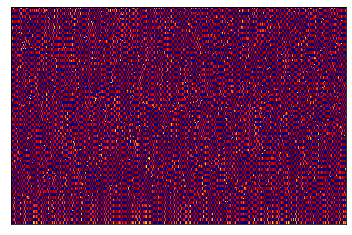

In [52]:
librosa.display.specshow(librosa.power_to_db(phase), cmap=cm.jet)

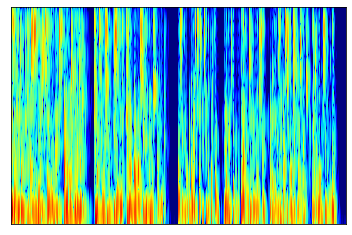

In [49]:
librosa.display.specshow(librosa.power_to_db(mag), cmap=cm.jet)

In [10]:
path="/Users/zombie/Downloads/datadrive/ljspeech/wavs/"
revPath="/Users/zombie/Downloads/datadrive/ljspeech/revWavs/"
checkpoint="/Users/zombie/Downloads/datadrive/smallCheckpoint3.5k_SSIM.pt"

In [11]:
from unet import UNet
net=UNet(1,1)
ckp=torch.load(checkpoint, map_location='cpu')
net.load_state_dict(ckp['modelStateDict'])

<All keys matched successfully>

In [15]:
out=net(batch[1])

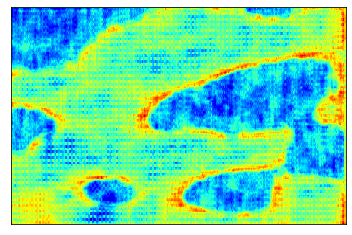

In [16]:
librosa.display.specshow(librosa.power_to_db(out[0][0].detach().numpy()), cmap=cm.jet)

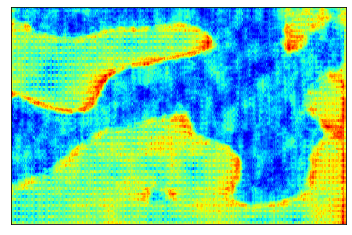

In [27]:
librosa.display.specshow(librosa.power_to_db(out[1][0].detach().numpy()), cmap=cm.jet)

## torchaudio vs librosa

In [3]:
wav="/Users/zombie/Downloads/datadrive/ljspeech/revWavs/LJ007-0005.wav"

In [4]:
w, _=torchaudio.load(wav)
stft=torch.stft(w, n_fft=1024, return_complex=True)

In [5]:
def complexToPolar(com):
    mag=torch.abs(com)
    angle=torch.angle(com)
    return mag, angle
def polarToComplex(mag, ang):
    imag=torch.cos(ang)+1j*torch.sin(ang)
    return mag*imag

In [8]:
polarToComplex(complexToPolar(stft)[0], complexToPolar(stft)[1])==stft

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False,  True, False],
         ...,
         [False, False, False,  ...,  True, False, False],
         [False, False,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False,  True,  True]]])

In [9]:
IPython.display.Audio(torch.istft(polarToComplex(complexToPolar(stft)[0], complexToPolar(stft)[1]), n_fft=1024), rate=22050)

In [10]:
polarToComplex(complexToPolar(stft)[0], complexToPolar(stft)[1]).shape

torch.Size([1, 513, 789])

In [11]:
IPython.display.Audio(librosa.istft(polarToComplex(complexToPolar(stft)[0], complexToPolar(stft)[1]).numpy()[0]), rate=22050)

In [119]:
# IPython.display.Audio(torch.istft(stft, n_fft=1024), rate=22050)

In [12]:
w, _=librosa.load(wav, sr=22050)
stft=librosa.stft(w, n_fft=1024)

In [13]:
def complexToPolar(com):
    mag=np.abs(com)
    angle=np.angle(com, deg=True)
    return mag, angle
def polarToComplex(mag, ang):
    imag=np.cos(ang)+1j*np.sin(ang)
    return mag*imag

In [14]:
polarToComplex(complexToPolar(stft)[0], complexToPolar(stft)[1])==stft

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [ True,  True,  True, ...,  True,  True,  True]])

In [15]:
polarToComplex(complexToPolar(stft)[0], complexToPolar(stft)[1]).shape

(513, 789)

In [16]:
IPython.display.Audio(librosa.istft(polarToComplex(complexToPolar(stft)[0], complexToPolar(stft)[1])), rate=22050)

In [167]:
IPython.display.Audio(torch.istft(torch.from_numpy(polarToComplex(complexToPolar(stft)[0], complexToPolar(stft)[1])), n_fft=1024), rate=22050)